In [1]:
%%capture --no-stderr
%pip install -U  langgraph

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [3]:
from typing import List, Optional, TypedDict, Annotated
from operator import add
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


class Log(TypedDict):
    id: int
    exec_time: Optional[float]
    cpu_usage: Optional[float]
    mem_usage: Optional[float]
    info: Optional[str]


### Created my own example graph and defined two subgraphs for it : 

#### subgraph 1 

In [4]:
class PerformanceEvaluationState(TypedDict):
    cleaned_logs: List[Log]
    perf_metrics: Optional[List[str]]
    summary: Optional[str]

def extract_performance_metrics(state):
    cleaned_logs = state["cleaned_logs"]
    metrics = [
        f"log-{log['id']}: time={log.get('exec_time', '--')}"
        for log in cleaned_logs
    ]
    return {"perf_metrics": metrics}

def summarize_performance(state):
    metrics = state.get("perf_metrics", [])
    summary = f"Performance summary for {len(metrics)} logs: " + ", ".join(metrics)
    return {"summary": summary}


#### subgraph 2

In [5]:
class ResourceUsageReportState(TypedDict):
    cleaned_logs: List[Log]
    usage_details: Optional[List[str]]
    usage_summary: Optional[str]

def extract_usage_details(state):
    cleaned_logs = state["cleaned_logs"]
    details = [
        f"log-{log['id']}: CPU={log.get('cpu_usage', '--')}, MEM={log.get('mem_usage', '--')}"
        for log in cleaned_logs
    ]
    return {"usage_details": details}

def summarize_usage(state):
    details = state.get("usage_details", [])
    summary = f"Resource usage summary for {len(details)} logs: " + "; ".join(details)
    return {"usage_summary": summary}


#### created the main graph

#### main graph

In [6]:
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: Annotated[List[Log], add]
    perf_metrics: Optional[List[str]]
    summary: Optional[str]
    usage_details: Optional[List[str]]
    usage_summary: Optional[str]

def clean_logs(state):
    raw_logs = state["raw_logs"]
    # Dummy cleaning function
    return {"cleaned_logs": raw_logs}


#### input

In [7]:
raw_logs = [
    {"id": 1, "exec_time": 0.15, "cpu_usage": 50, "mem_usage": 100, "info": "Task finished"},
    {"id": 2, "exec_time": 0.23, "cpu_usage": 60, "mem_usage": 110, "info": "Task slow"},
]


#### compiled and displayed both the subgraphs

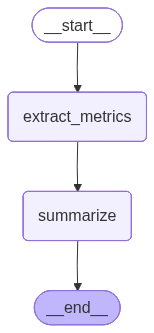

In [8]:
# Performance subgraph
perf_builder = StateGraph(PerformanceEvaluationState)
perf_builder.add_node("extract_metrics", extract_performance_metrics)
perf_builder.add_node("summarize", summarize_performance)
perf_builder.add_edge(START, "extract_metrics")
perf_builder.add_edge("extract_metrics", "summarize")
perf_builder.add_edge("summarize", END)
graph = perf_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))






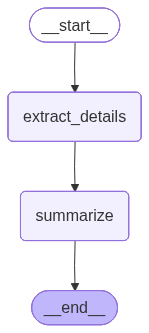

In [9]:
# Resource usage subgraph
usage_builder = StateGraph(ResourceUsageReportState)
usage_builder.add_node("extract_details", extract_usage_details)
usage_builder.add_node("summarize", summarize_usage)
usage_builder.add_edge(START, "extract_details")
usage_builder.add_edge("extract_details", "summarize")
usage_builder.add_edge("summarize", END)
graph = usage_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

#### compiled amd displayed the main graph along with xray to also show the subgraph

In [10]:
entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("clean_logs", clean_logs)
entry_builder.add_node("performance_evaluation", perf_builder.compile())
entry_builder.add_node("resource_usage", usage_builder.compile())

entry_builder.add_edge(START, "clean_logs")
entry_builder.add_edge("clean_logs", "performance_evaluation")
entry_builder.add_edge("clean_logs", "resource_usage")
entry_builder.add_edge("performance_evaluation", END)
entry_builder.add_edge("resource_usage", END)

graph = entry_builder.compile()


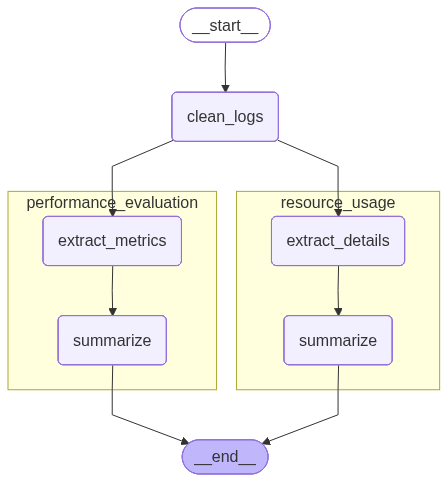

In [11]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

### tested the graph and subgraphs with an input :

In [ ]:
result = graph.invoke({"raw_logs": raw_logs})
print(result)


{'raw_logs': [{'id': 1, 'exec_time': 0.15, 'cpu_usage': 50, 'mem_usage': 100, 'info': 'Task finished'}, {'id': 2, 'exec_time': 0.23, 'cpu_usage': 60, 'mem_usage': 110, 'info': 'Task slow'}], 'cleaned_logs': [{'id': 1, 'exec_time': 0.15, 'cpu_usage': 50, 'mem_usage': 100, 'info': 'Task finished'}, {'id': 2, 'exec_time': 0.23, 'cpu_usage': 60, 'mem_usage': 110, 'info': 'Task slow'}, {'id': 1, 'exec_time': 0.15, 'cpu_usage': 50, 'mem_usage': 100, 'info': 'Task finished'}, {'id': 2, 'exec_time': 0.23, 'cpu_usage': 60, 'mem_usage': 110, 'info': 'Task slow'}, {'id': 1, 'exec_time': 0.15, 'cpu_usage': 50, 'mem_usage': 100, 'info': 'Task finished'}, {'id': 2, 'exec_time': 0.23, 'cpu_usage': 60, 'mem_usage': 110, 'info': 'Task slow'}], 'perf_metrics': ['log-1: time=0.15', 'log-2: time=0.23'], 'summary': 'Performance summary for 2 logs: log-1: time=0.15, log-2: time=0.23', 'usage_details': ['log-1: CPU=50, MEM=100', 'log-2: CPU=60, MEM=110'], 'usage_summary': 'Resource usage summary for 2 logs: 

Failed to multipart ingest runs: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')trace=ab747d04-d3ec-482e-a885-5e64fb40282d,id=ab747d04-d3ec-482e-a885-5e64fb40282d; trace=ab747d04-d3ec-482e-a885-5e64fb40282d,id=0f421062-c524-4552-9600-503919e0cb95; trace=ab747d04-d3ec-482e-a885-5e64fb40282d,id=588a8714-e315-42a1-ac5e-a66a62d14b4f; trace=ab747d04-d3ec-482e-a885-5e64fb40282d,id=75ec6ca0-c620-40bb-8888-0cf069765ae1; trace=ab747d04-d3ec-482e-a885-5e64fb40282d,id=1cc16e61-3d54-49b1-8082-6b282c2f38c6; trace=ab747d04-d3ec-482e-a885-5e64fb40282d,id=455b89fa-d280-4785-b01a-6afa29adb7df; trace=ab747d04-d3ec-482e-a885-5e64fb40282d,id=c2bea6d9-43b5-437f-adf8-c1e190ba857a; trace=ab747d04-d3ec-482e-a885-5e64fb40282d,id=93825e1

### testing with another input

In [13]:
raw_logs = [
    {"id": 3, "exec_time": 0.31, "cpu_usage": 49, "mem_usage": 115, "info": "Completed successfully"},
    {"id": 4, "exec_time": 0.12, "cpu_usage": 85, "mem_usage": 140, "info": "Memory spike detected"},
    {"id": 5, "exec_time": 0.50, "cpu_usage": 32, "mem_usage": 90, "info": "Low CPU operation"},
]


In [14]:
result = graph.invoke({"raw_logs": raw_logs})
print(result)

{'raw_logs': [{'id': 3, 'exec_time': 0.31, 'cpu_usage': 49, 'mem_usage': 115, 'info': 'Completed successfully'}, {'id': 4, 'exec_time': 0.12, 'cpu_usage': 85, 'mem_usage': 140, 'info': 'Memory spike detected'}, {'id': 5, 'exec_time': 0.5, 'cpu_usage': 32, 'mem_usage': 90, 'info': 'Low CPU operation'}], 'cleaned_logs': [{'id': 3, 'exec_time': 0.31, 'cpu_usage': 49, 'mem_usage': 115, 'info': 'Completed successfully'}, {'id': 4, 'exec_time': 0.12, 'cpu_usage': 85, 'mem_usage': 140, 'info': 'Memory spike detected'}, {'id': 5, 'exec_time': 0.5, 'cpu_usage': 32, 'mem_usage': 90, 'info': 'Low CPU operation'}, {'id': 3, 'exec_time': 0.31, 'cpu_usage': 49, 'mem_usage': 115, 'info': 'Completed successfully'}, {'id': 4, 'exec_time': 0.12, 'cpu_usage': 85, 'mem_usage': 140, 'info': 'Memory spike detected'}, {'id': 5, 'exec_time': 0.5, 'cpu_usage': 32, 'mem_usage': 90, 'info': 'Low CPU operation'}, {'id': 3, 'exec_time': 0.31, 'cpu_usage': 49, 'mem_usage': 115, 'info': 'Completed successfully'}, {'

#### this is how the organised form of the subgraphs appear in the langsmith webstie, all the subgraphs appear as collapsible elements which we can open to see what's going on inside:

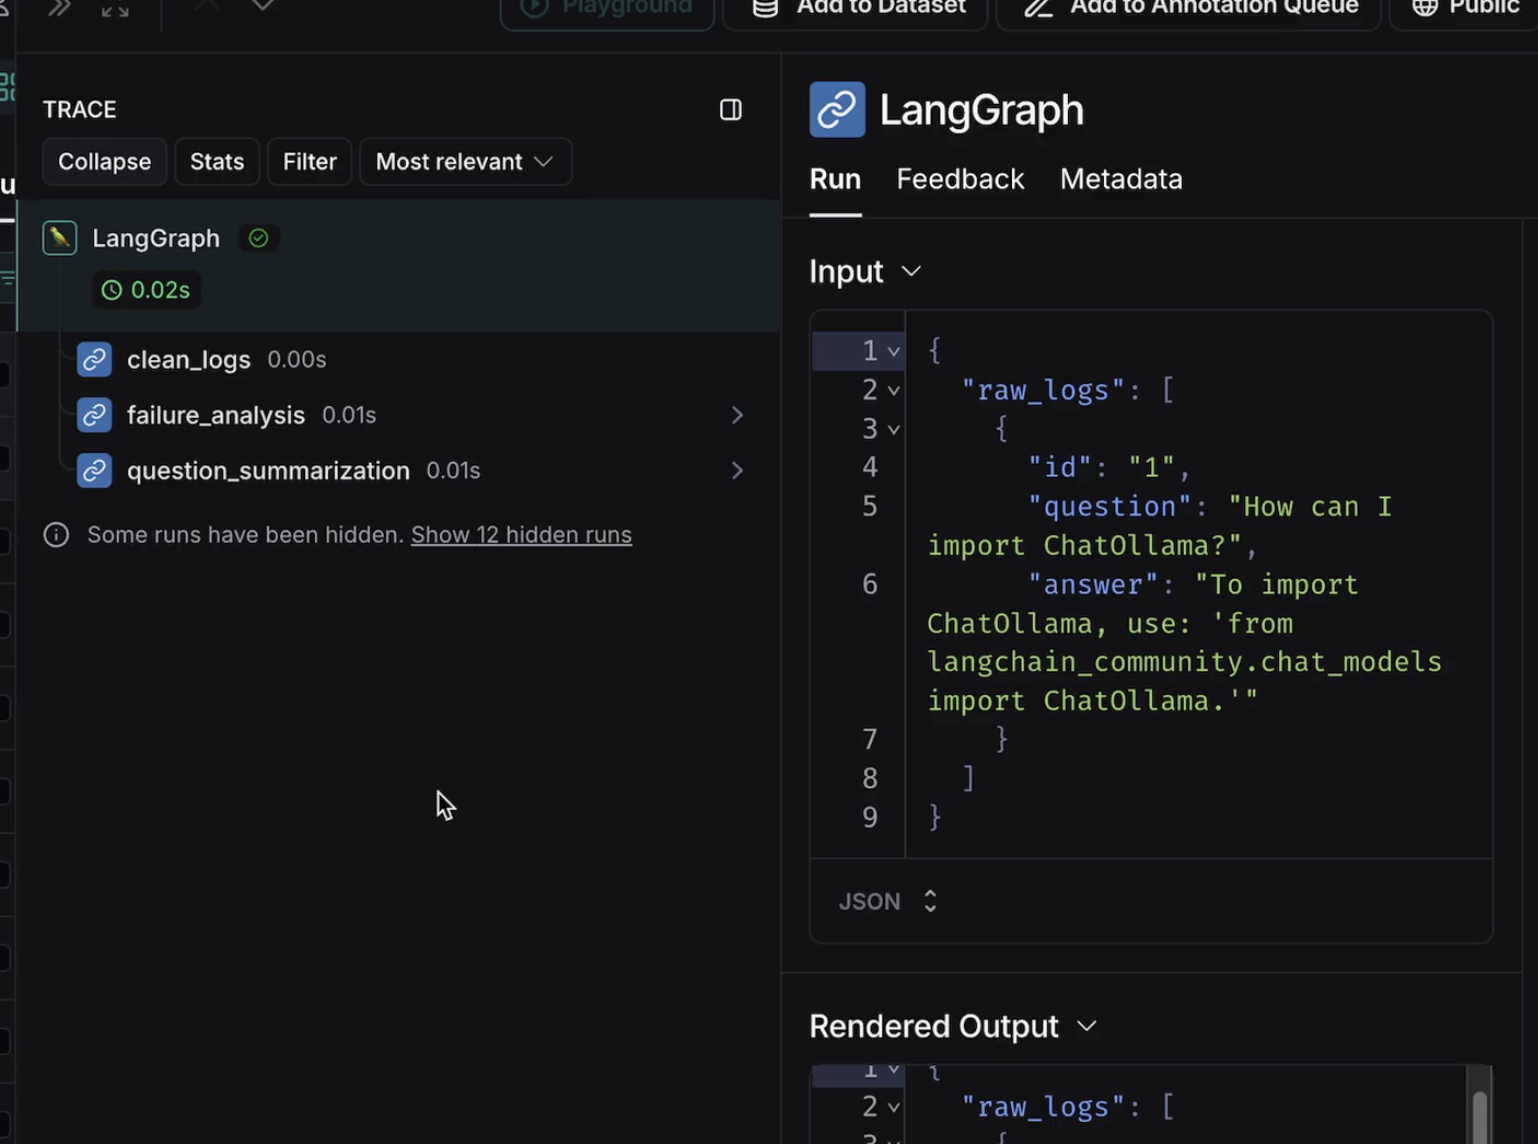